Equations for transient Euler-Bernoulli beam:

$$\mu \frac{d^2w}{dt^2} + \frac{d^2}{dx^2} \left( EI \frac{d^2w}{dx^2} \right) = q$$

$$-EI \frac{d^2w}{dx^2} = M$$

$$-\frac{d}{dx} \left( EI \frac{d^2w}{dx^2} \right) = Q$$

$E$: Young's modulus \
$I$: moment of inertia \
$\mu$: linear mass density




### Possible Improvements

- use hyperparameter tuning to improve training efficiency
- implement interpolation and use it for E in the section on parameter identification

---------------

available hardware acceleration

In [1]:
import torch
import warnings
warnings.filterwarnings('ignore', message='Attempting to run cuBLAS, but there was no current CUDA context!')

n_devices = torch.cuda.device_count()
print(f"number of CUDA devices available: {n_devices}")
for i in range(n_devices):
    device_name = f"cuda:{i}"
    print(f"\t \"{device_name}\" ({torch.cuda.get_device_name(device=device_name)})")


number of CUDA devices available: 1
	 "cuda:0" (Tesla M40 24GB)


## Data Driven Inference

define a class for the FFNN

In [2]:
import torch
import torch.nn as nn
import random
import time
import numpy as np
from IPython.display import display, clear_output, update_display
import matplotlib.pyplot as plt
%matplotlib widget

class FFNN(torch.nn.Module):
    def __init__(self, layers, nonlinearity="sigmoid", device="cpu"):
        super(FFNN, self).__init__()
        self.device = device
        
        self.layers = layers
        self.dtype = torch.float32
        
        modules = []
        for i in range(len(layers) - 1):
            modules.append(nn.Linear(layers[i], layers[i + 1], bias=(i < len(layers) - 2)))
            if i < len(layers) - 2:  # apply nonlinearity for all but the last layer
                if nonlinearity == "sigmoid":
                    modules.append(nn.Sigmoid())
                elif nonlinearity == "tanh":
                    modules.append(nn.Tanh())
                elif nonlinearity == "relu":
                    modules.append(nn.ReLU())
                elif nonlinearity == "leaky_relu":
                    modules.append(nn.LeakyReLU())
                elif nonlinearity == "softplus":
                    modules.append(nn.Softplus())
                else:
                    raise ValueError("Invalid nonlinearity.")

        # Use nn.Sequential to create the network
        self.network = nn.Sequential(*modules).to(device=self.device, dtype=self.dtype)

    
    def forward(self, x):
        #print(f"shape of x: {x.shape}")
        x = x.to(self.device, dtype=self.dtype)
        return self.network(x)
        
        return y #.to("cpu")




definition of the beam model

In [3]:
# parameters
l = 1. # length of the beam (left end is at x=0)
E = lambda x: 1. # Young's modulus
I = lambda x: 1. # moment of inertia
mu = lambda x: 1. # linear mass density

dynamic = True # whether the simulation should include dnamic effects
t_end = 0.1 if dynamic else 0 # time, at which the simulation ends (start time is t=0)

n_samples_t = 5 if dynamic else 1
n_samples_x = 5000

# boundary conditions
# clamped --> (w, w_x)
# free --> (Q, M)
# pinned --> (w, M)
bcs = {"left boundary": {"x": 0, "type": "clamped", "values": (0., 0.)},
       "right boundary": {"x": 1, "type": "free", "values": (0., 0.)}}
q = lambda x: 0.

# initial conditions
ics = {"w": lambda x: 1/24*(x**4 - 4*x**3 + 6*x**2), "w_t": lambda x: 0.}

#def batched_grad(inputs, outputs, create_graph):
#    print(f"input shape for batched gradients: {inputs.shape}")
#    print(inputs[0])
#    print(outputs[0])
#    return torch.stack([torch.autograd.grad(inputs=inputs[i], outputs=outputs[i], create_graph=create_graph) for i in range(len(inputs))])

def comp_loss(t, x, w, E, I):
    loss = {key: torch.tensor([], device=t.device) for key in ["pde", "w", "w_x", "Q", "M", "w_i", "w_t_i"]}
    grad_output = torch.ones_like(t, device=x.device)

    # pde
    w_x = torch.autograd.grad(inputs=x, outputs=w, grad_outputs=grad_output, create_graph=True, retain_graph=True)[0]
    w_xx = torch.autograd.grad(inputs=x, outputs=w_x, grad_outputs=grad_output, create_graph=True, retain_graph=True)[0]

    general_general_reations = True
    if general_general_reations:
        # general relations for E(x)
        eiw_xx = E(x)*I(x)*w_xx
        eiw_xx_x = torch.autograd.grad(inputs=x, outputs=eiw_xx, grad_outputs=grad_output, create_graph=True, retain_graph=True)[0]
        eiw_xx_xx = torch.autograd.grad(inputs=x, outputs=eiw_xx_x, grad_outputs=grad_output, create_graph=True, retain_graph=True)[0]
        #if random.random() > 0.97:
        #    print(f"E: {E(0):.2f}")
    else:
        # simplified relations assuming E=const
        w_xxx = torch.autograd.grad(inputs=x, outputs=w_xx, grad_outputs=grad_output, create_graph=True, retain_graph=True)[0]
        w_xxxx = torch.autograd.grad(inputs=x, outputs=w_xxx, grad_outputs=grad_output, create_graph=True, retain_graph=True)[0]

        eiw_xx = E(x)*I(x)*w_xx
        eiw_xx_x = E(x)*I(x)*w_xxx
        eiw_xx_xx = E(x)*I(x)*w_xxxx
        #if random.random() > 0.97:
        #    print(f"w_xxxx_mean: {w_xxxx.mean():.2f}, E: {E(0):.2f}")

    w_t = torch.autograd.grad(inputs=t, outputs=w, grad_outputs=grad_output, create_graph=True, retain_graph=True)[0]
    w_tt = torch.autograd.grad(inputs=t, outputs=w_t, grad_outputs=grad_output, create_graph=True, retain_graph=True)[0]
    muw_tt = mu(x)*w_tt

    loss["pde"] = (muw_tt*dynamic + eiw_xx_xx - q(x))**2

    # boundary conditions
    for bc_name in bcs:
        bc = bcs[bc_name]

        # initial conditions take precedence in the dynamic case
        if dynamic:
            boundary_mask = torch.logical_and(x == bc["x"], (t > 0))
        else:
            boundary_mask = x == bc["x"]

        if boundary_mask.sum() > 0:
            if bc["type"] == "clamped":
                loss["w"] = torch.concatenate([loss["w"], (w[boundary_mask] - bc["values"][0])**2]) # w
                loss["w_x"] = torch.concatenate([loss["w_x"], (w_x[boundary_mask] - bc["values"][1])**2]) # w_x
    
            elif bc["type"] == "free":
                loss["Q"] = torch.concatenate([loss["Q"], (-eiw_xx_x[boundary_mask] - bc["values"][0])**2]) # Q
                loss["M"] = torch.concatenate([loss["M"], (-eiw_xx[boundary_mask] - bc["values"][1])**2]) # M

            elif bc["type"] == "pinned":
                loss["w"] = torch.concatenate([loss["w"], (w[boundary_mask] - bc["values"][0])**2]) # w
                loss["M"] = torch.concatenate([loss["M"], (-eiw_xx[boundary_mask] - bc["values"][1])**2]) # M
            else:
                raise ValueError(f"invalid type of boundary condition: {bc['type']}")

    # initial conditions
    if dynamic:
        ic_mask = t == 0.
        #print(x[ic_mask])
        #print(ics["w"](x[ic_mask]))
        if ic_mask.sum() > 0:
            loss["w_i"] = torch.concatenate([loss["w_i"] , (w[ic_mask] - ics["w"](x[ic_mask]))**2]) # w
            loss["w_t_i"] = torch.concatenate([loss["w_t_i"], (w_t[ic_mask] - ics["w_t"](x[ic_mask]))**2]) # w_t

    loss = {key: (l.mean() if len(l) > 0 else torch.tensor(0., dtype=t.dtype, device=t.device)) for key, l in zip(loss.keys(), loss.values())}
    
    return loss

meshgrid = torch.meshgrid(torch.linspace(0, t_end, n_samples_t),
                           torch.linspace(0, l, n_samples_x))
points_t = meshgrid[0].reshape(-1,1)
points_x = meshgrid[1].reshape(-1,1)



/home/jovyan/.conda/envs/paml_env_pytorch/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


class for visualization

In [4]:
class Visualization:
    def __init__(self, model, l, t_end, plot_interval=10, dynamic=True):
        self.model=model
        self.l = l
        self.t_end = t_end
        self.plot_interval = plot_interval
        self.dynamic = dynamic
        self.deflection_limits = None

        self.fig = self.axs = None
        self.vis_data = None
        self.figsize = (8, 12)

    
    def vis(self, vis_data):
        vis_data = {plot_key: {key: [value] for key, value in zip(plot_data.keys(), plot_data.values())} for plot_key, plot_data in zip(vis_data.keys(), vis_data.values())}
        if self.vis_data is None or not len(vis_data) == len(self.vis_data):
            self.vis_data = vis_data
            self.fig, self.axs = plt.subplots(len(vis_data) + 1, 1, figsize=self.figsize)
            self.display_id = 'display_id'+str(random.random())
            display(self.fig, display_id=self.display_id)
        else:
            for plot_key in vis_data:
                for data_field in vis_data[plot_key]:
                    self.vis_data[plot_key][data_field] += vis_data[plot_key][data_field]

        if (iter_index + 1) % self.plot_interval == 0:
            for plot_index, plot_key in enumerate(self.vis_data):

                title = plot_key
                data_x = list(self.vis_data[plot_key].values())[0]
                data_y = list(self.vis_data[plot_key].values())[1]
                label_x = list(self.vis_data[plot_key].keys())[0]
                label_y = list(self.vis_data[plot_key].keys())[1]
                self.axs[plot_index].clear()
                self.axs[plot_index].plot(data_x, data_y)
                self.axs[plot_index].set_xlabel(label_x)
                self.axs[plot_index].set_ylabel(label_y)
                self.axs[plot_index].set_yscale("log" if "loss" in label_y or "learning rate" in label_y else "linear")
                self.axs[plot_index].set_title(title)
                self.axs[plot_index].grid(True)

                plot_index = len(self.vis_data)
                self.axs[plot_index].clear()
                if self.deflection_limits is not None:
                    deflection_delta = self.deflection_limits[1] - self.deflection_limits[0]
                    self.deflection_limits[0] = self.deflection_limits[0] + deflection_delta*0.01
                    self.deflection_limits[1] = self.deflection_limits[1] - deflection_delta*0.01
            for t_i in np.linspace(0, self.t_end, 3 if self.dynamic else 1):
                x_eval = torch.linspace(0, self.l, 100, dtype=self.model.dtype).reshape(-1,1)
                t_eval = t_i*torch.ones_like(x_eval, dtype=self.model.dtype).reshape(-1,1)
                self.model.eval()
                w_eval = self.model(torch.concatenate([t_eval, x_eval], dim=1)).detach().to("cpu")[:,0].reshape(-1,1)

                if self.deflection_limits is None:
                    self.deflection_limits = [w_eval.min(), w_eval.max()]
                else:
                    self.deflection_limits[0] = min(w_eval.min(), self.deflection_limits[0])
                    self.deflection_limits[1] = max(w_eval.max(), self.deflection_limits[1])

                self.axs[plot_index].plot(x_eval, w_eval, label=f"t={t_i:.2f}")
                
            self.axs[plot_index].set_xlabel("x in m")
            self.axs[plot_index].set_ylabel("w in m")
            deflection_delta = self.deflection_limits[1] - self.deflection_limits[0]
            self.axs[plot_index].set_ylim([self.deflection_limits[0] - 0.1*deflection_delta, self.deflection_limits[1] + 0.1*deflection_delta])
            self.axs[plot_index].set_title("deflection for different points in time")
            self.axs[plot_index].grid(True)
            if self.dynamic:
                self.axs[plot_index].legend()

            
            plt.tight_layout()
            update_display(self.fig, display_id=self.display_id)
            #plt.savefig('training_plot_cnn.svg', format='svg')
            #plt.pause(0.1)
            
            #print(f"w_x_mean_actual: {w_eval[x_eval == x_eval.max()].mean() - w_eval[x_eval == x_eval.min()].mean()}")



function for retrieving batches of samples

In [5]:
def get_batch(data, iter_index, batch_size, random_samples=False):
    data_len = len(data[0])
    if random_samples:
        batch_indices = torch.randperm(data_len)[:batch_size]
    else:
        start_index = (iter_index*batch_size) % data_len
        stop_index = ((iter_index + 1)*batch_size) % data_len
        batch_indices = np.arange(start_index, stop_index)
        if start_index > stop_index:
            start_index -= data_len
        batch_indices = np.arange(start_index, stop_index)

    batch_data = []
    for input in data:
        batch_data.append(input[batch_indices].reshape(-1,1))

    #return tuple(d.to(ffnn.device) for d in batch_data)
    return tuple(batch_data)

training

In [ ]:
torch.manual_seed(0) # ensure reproducibility

layers_widths = [2, 200, 200, 1]

ffnn = FFNN(layers_widths, nonlinearity="tanh", device="cuda:0")

print(ffnn.network)
#print(list(ffnn.layers["layer_0"].parameters())[0])
#print(list(ffnn.layers["layer_1"].parameters())[0])
#print(list(ffnn.layers["layer_2"].parameters())[0])
#time.sleep(100)

optimizer = torch.optim.NAdam(params=ffnn.parameters(), lr=0.001, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

visualization = Visualization(model=ffnn, l=l, t_end=t_end, plot_interval=50, dynamic=dynamic)

x = points_x.type(ffnn.dtype).requires_grad_().to(ffnn.device)
t = (points_t).type(ffnn.dtype).requires_grad_().to(ffnn.device)

batch_size = n_samples_t*n_samples_x # int(n_samples_t*n_samples_x / 3 - 1)

maxiter = 100000
        
iter_index = 0
scheduler_index = 0
while True:
    #print(f"iteration {iter_index + 1}")
    ffnn.zero_grad()
    ffnn.train()

    t_i, x_i = get_batch([t, x], iter_index, batch_size, random_samples=True)
    w = ffnn(torch.concatenate([t_i, x_i], dim=1))

    #w_x = torch.autograd.grad(inputs=x_i, outputs=w, create_graph=True, retain_graph=True)[0]
    #print(f"x_i: {x_i}")
    #print(f"w: {w}")
    #print(f"w_x: {w_x}")

    losses = comp_loss(t_i, x_i, w, E=E, I=I)
    
    loss_sum = sum(losses.values()) # !!!!!!!!!!!!!!!!!make it so the losses have the same orders of magnitude?!!!!!!!!!!!!!!!!
    loss_normalized = 0.
    #norm_value = torch.concatenate([v.reshape(1,1) for v in losses.values()]).max()
    #print(f"max loss: {norm_value}")
    tolerances = {"pde": 1e-2, "w": 1e-2, "w_x": 1e-2, "Q": 1e-2, "M": 1e-2, "w_i": 1e-5, "w_t_i": 1e-4}
    for loss_key, loss_comp in zip(losses.keys(), losses.values()):
        if loss_comp > 0:
            loss_normalized = loss_normalized + loss_comp /(loss_comp.detach() + tolerances[loss_key])

    losses["pde"] = 1.*losses["pde"]
    losses["w"] = 5.*losses["w"]
    losses["w_x"] = 1.*losses["w_x"]
    losses["Q"] = 1.*losses["Q"]
    losses["M"] = 1.*losses["M"]
    losses["w_i"] = 2.*losses["w_i"]
    losses["w_t_i"] = 1.*losses["w_t_i"]

    loss_normalized = sum(losses.values())
    #print(f"loss: {loss}")
    loss_normalized.backward()
    optimizer.step()

    #print(f"gradient: {list(ffnn.layers['layer_1'].parameters())[0].grad}")

    #print(f"loss: {loss}")
    #print(iter_index)
    #print(loss)
    losses = {key: value.to("cpu") for key, value in zip(losses.keys(), losses.values())}
    loss_normalized = loss_normalized.to("cpu")
    vis_data = {"total loss over iterations": {"iterations": iter_index+1, "total loss": loss_normalized.detach()},
                "learning rate over iterations": {"iterations": iter_index+1, "learning rate": lr_scheduler.get_last_lr()},
                "PDE-loss over iterations": {"iterations": iter_index+1, "PDE-loss": losses["pde"].detach()},
                "w-loss over iterations": {"iterations": iter_index+1, "w-loss": losses["w"].detach()},
                "w_i-loss over iterations": {"iterations": iter_index+1, "w_i-loss": losses["w_i"].detach()},
                "w_t_i-loss over iterations": {"iterations": iter_index+1, "w_t_i-loss": losses["w_t_i"].detach()},
                "Q-loss over iterations": {"iterations": iter_index+1, "Q-loss": losses["Q"].detach()}}
    visualization.vis(vis_data)

    iter_index += 1

    scheduler_index += batch_size
    if scheduler_index > len(t):
        scheduler_index = scheduler_index % len(t)
        lr_scheduler.step()
        #print(f"new learning rate: {lr_scheduler.get_last_lr()[0]:.2e}")

    if iter_index == maxiter:
        break

#grad_x = torch.autograd.grad(inputs=x, outputs=y, create_graph=True) # create graph for gradients, so that they can be used in the loss function    

#print(f"gradient of x: {grad_x}")

print("done")

## parameter Identification

Sequential(
  (0): Linear(in_features=2, out_features=14, bias=True)
  (1): Tanh()
  (2): Linear(in_features=14, out_features=14, bias=True)
  (3): Tanh()
  (4): Linear(in_features=14, out_features=2, bias=False)
)


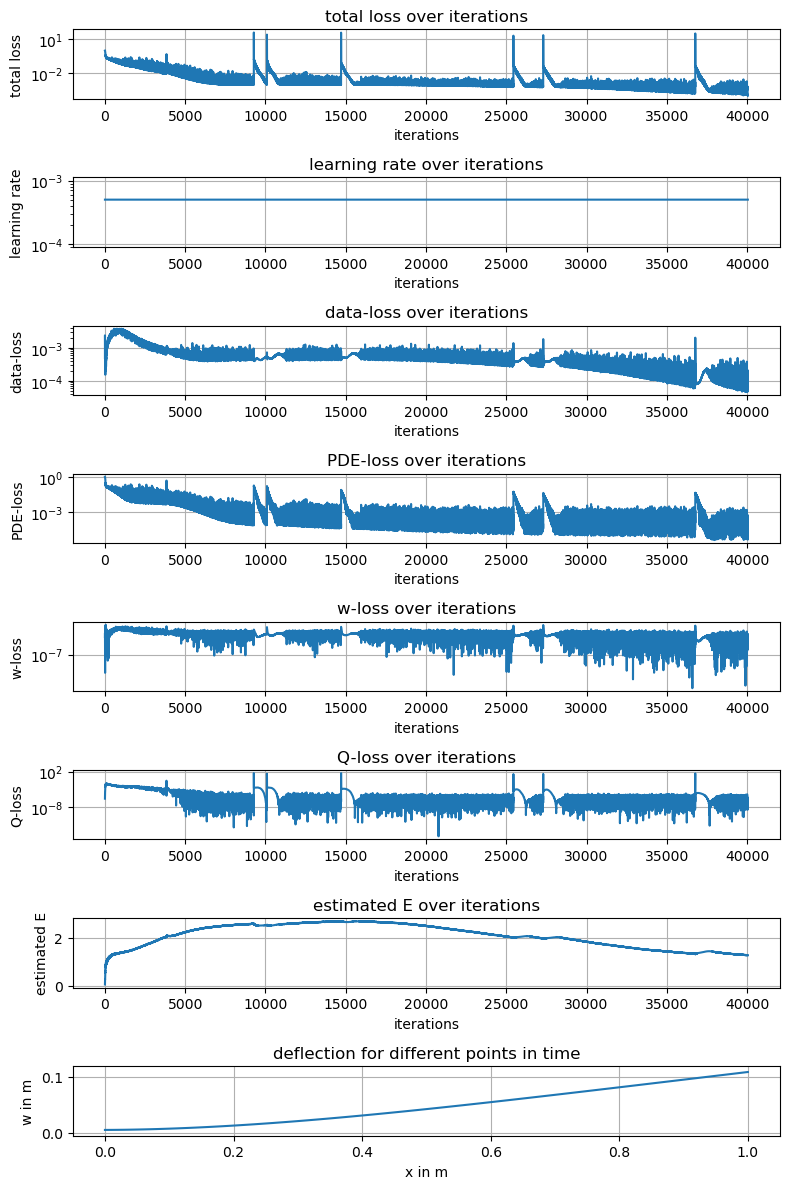

E: 0.26
E: 0.72
E: 1.06
E: 1.12
E: 1.13
E: 1.17
E: 1.24
E: 1.26
E: 1.29
E: 1.27
E: 1.29
E: 1.30
E: 1.31
E: 1.29
E: 1.28
E: 1.31
E: 1.31
E: 1.33
E: 1.34
E: 1.34
E: 1.33
E: 1.34
E: 1.35
E: 1.34
E: 1.36
E: 1.37
E: 1.38
E: 1.37
E: 1.38
E: 1.38
E: 1.38
E: 1.39
E: 1.39
E: 1.41
E: 1.41
E: 1.41
E: 1.40
E: 1.40
E: 1.43
E: 1.44
E: 1.44
E: 1.45
E: 1.46
E: 1.47
E: 1.47
E: 1.48
E: 1.48
E: 1.48
E: 1.50
E: 1.51
E: 1.52
E: 1.53
E: 1.53
E: 1.54
E: 1.55
E: 1.56
E: 1.57
E: 1.56
E: 1.57
E: 1.57
E: 1.58
E: 1.60
E: 1.60
E: 1.60
E: 1.62
E: 1.62
E: 1.62
E: 1.65
E: 1.67
E: 1.69
E: 1.71
E: 2.12
E: 2.11
E: 2.12
E: 2.11
E: 2.13
E: 2.14
E: 2.17
E: 2.16
E: 2.17
E: 2.17
E: 2.17
E: 2.17
E: 2.18
E: 2.19
E: 2.19
E: 2.20
E: 2.20
E: 2.20
E: 2.21
E: 2.23
E: 2.23
E: 2.23
E: 2.24
E: 2.24
E: 2.23
E: 2.24
E: 2.24
E: 2.25
E: 2.25
E: 2.26
E: 2.26
E: 2.26
E: 2.26
E: 2.27
E: 2.28
E: 2.29
E: 2.31
E: 2.30
E: 2.31
E: 2.31
E: 2.31
E: 2.33
E: 2.34
E: 2.34
E: 2.35
E: 2.35
E: 2.36
E: 2.35
E: 2.37
E: 2.37
E: 2.37
E: 2.38
E: 2.38
E: 2.39


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fb4c632a320>
Traceback (most recent call last):
  File "/home/jovyan/.conda/envs/paml_env_pytorch/lib/python3.10/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
KeyboardInterrupt: 

KeyboardInterrupt



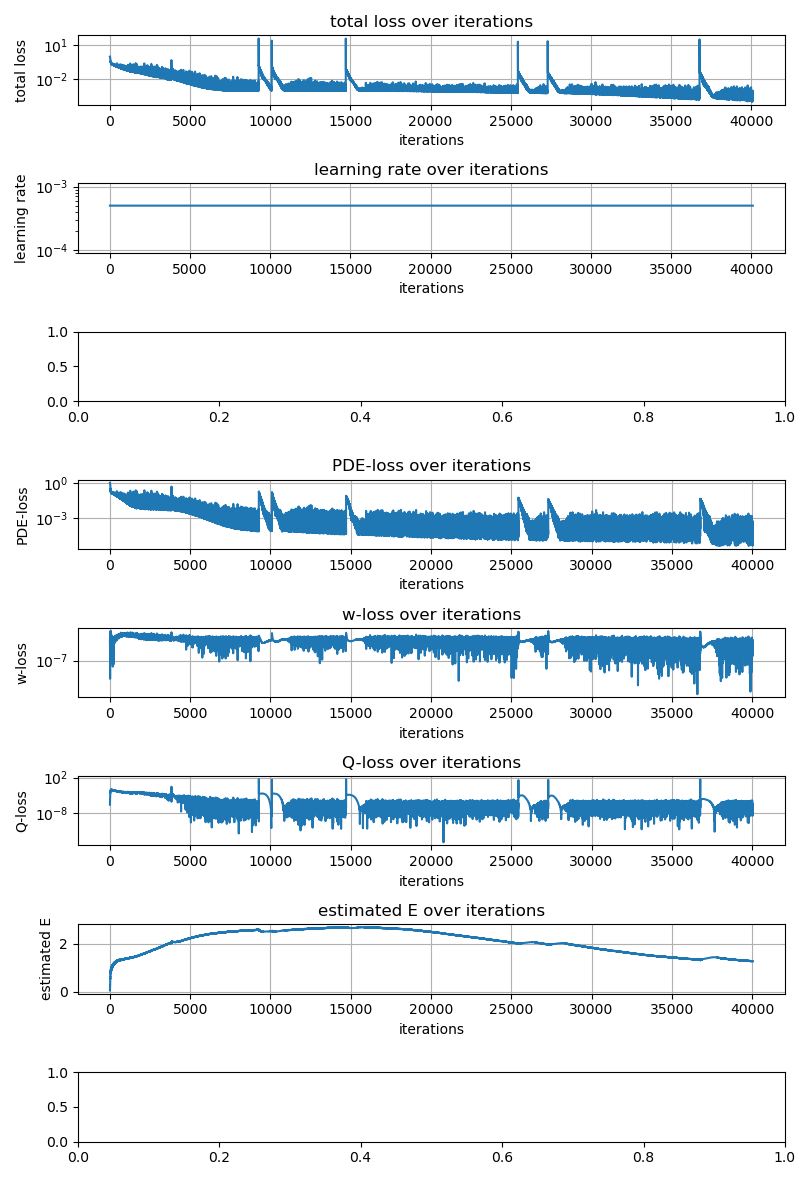

In [13]:
torch.manual_seed(0) # ensure reproducibility

# adaptation of the problem
q = lambda x: 1. # without a line load E connot be uniquely identified
w_ana =  lambda x: 1/24*(x**4 - 4*x**3 + 6*x**2)
dynamic = False
n_samples_t = 1
t_end = 0


layers_widths = [2, 15, 15, 2]
ffnn = FFNN(layers_widths, nonlinearity="tanh", device="cuda:0")

print(ffnn.network)

# for some reason here RMSprop works better than Adam (with a sufficiently low learning rate)
#optimizer = torch.optim.Adam(params=ffnn.parameters(), lr=0.0005, weight_decay=0)
optimizer = torch.optim.RMSprop(params=ffnn.parameters(), lr=0.0005, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

visualization = Visualization(model=ffnn, l=l, t_end=t_end, plot_interval=50, dynamic=dynamic)

x = (points_x[points_t == 0]).type(ffnn.dtype).requires_grad_().to(ffnn.device)
t = (points_t[points_t == 0]).type(ffnn.dtype).requires_grad_().to(ffnn.device)

# new samples with known values for w
n_data = 5000
t_data = torch.zeros((n_data, 1), dtype=ffnn.dtype, device=ffnn.device)
x_data = torch.linspace(0., l, n_data, dtype=ffnn.dtype, device=ffnn.device).reshape(-1,1)

batch_size = 5000 #n_samples_x
maxiter = np.inf
        
iter_index = 0
scheduler_index = 0
while True:
    #print(f"iteration {iter_index + 1}")
    ffnn.zero_grad()
    ffnn.train()

    t_i, x_i = get_batch([t, x], iter_index, batch_size, random_samples=True)
    out = ffnn(torch.concatenate([t_i, x_i], dim=1))
    w = out[:,0].reshape(-1,1)
    E = out[:,1]
    E = E[torch.randperm(len(E))][0] # select a random element from E --> interpolation would be more general, but isn't supported by PyTorch out of the box

    #w_x = torch.autograd.grad(inputs=x_i, outputs=w, create_graph=True, retain_graph=True)[0]
    #print(f"x_i: {x_i}")
    #print(f"w: {w}")
    #print(f"w_x: {w_x}")

    losses = comp_loss(t_i, x_i, w, E=lambda x: E, I=I)

    # compute data loss
    data_indices = torch.randperm(len(t_data))[:int(len(t_data)/1)] # choose random batches from PDE data
    t_data_i = t_data[data_indices]
    x_data_i = x_data[data_indices]
    out_data = ffnn(torch.concatenate([t_data_i, x_data_i], dim=1))
    w_data = out_data[:,0].reshape(-1,1)
    losses["data"] = ((w_data - w_ana(x_data_i))**2).mean()
    # convergence can be sped up a lot by enforcing a constant value of E across the length of the beam
    #E_x = torch.autograd.grad(inputs=x, outputs=E, grad_outputs=torch.ones_like(E, device=x_data_i.device), create_graph=True, retain_graph=True)[0]
    #losses["E_x"] = E_x.mean()**2
    

    losses["pde"] = 1.*losses["pde"]
    losses["w"] = 1.*losses["w"]
    losses["w_x"] = 1.*losses["w_x"]
    losses["Q"] = 1.*losses["Q"]
    losses["M"] = 1.*losses["M"]
    losses["w_i"] = 1.*losses["w_i"]
    losses["w_t_i"] = 1.*losses["w_t_i"]
    losses["data"] = 1.*losses["data"]
    #losses["E_x"]  = 1.*losses["E_x"]

    loss_normalized = sum(losses.values())
    #print(f"loss: {loss}")
    loss_normalized.backward()
    optimizer.step()

    if random.random() > 0.97:
        print(f"E: {E.mean().item():.2f}")
    
    losses = {key: value.to("cpu") for key, value in zip(losses.keys(), losses.values())}
    loss_normalized = loss_normalized.to("cpu")
    E = E.to("cpu")
    vis_data = {"total loss over iterations": {"iterations": iter_index+1, "total loss": loss_normalized.detach()},
                "learning rate over iterations": {"iterations": iter_index+1, "learning rate": lr_scheduler.get_last_lr()},
                "data-loss over iterations": {"iterations": iter_index+1, "data-loss": losses["data"].detach()},
                "PDE-loss over iterations": {"iterations": iter_index+1, "PDE-loss": losses["pde"].detach()},
                "w-loss over iterations": {"iterations": iter_index+1, "w-loss": losses["w"].detach()},
                "Q-loss over iterations": {"iterations": iter_index+1, "Q-loss": losses["Q"].detach()},
                "estimated E over iterations": {"iterations": iter_index+1, "estimated E": E.detach()}}
    visualization.vis(vis_data)

    iter_index += 1

    scheduler_index += batch_size
    if scheduler_index > len(t):
        scheduler_index = scheduler_index % len(t)
        lr_scheduler.step()
        #print(f"new learning rate: {lr_scheduler.get_last_lr()[0]:.2e}")

    if iter_index == maxiter:
        break





